# Testing of UNet Image-generation Pipeline

- main package: pipeline_utilities

In [1]:
import os
import sys
import pipeline_utilities as pu
import matplotlib.pyplot as plt

#start = int(sys.argv[1])
#end = int(sys.argv[2])
start, end = 0, 1  # change values during testing

hbn_dir = '/oak/stanford/groups/jyeatman/HBN/BIDS_curated/derivatives/freesurfer'
hbn_subjects = [s for s in os.listdir(hbn_dir) if s[:4]=='sub-']

save_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data/atlas/sulc'
save_x_subdir = 'xs'
save_y_subdir = 'ys'
save_xdir = os.path.join(save_base_dir, save_x_subdir)
save_ydir = os.path.join(save_base_dir, save_y_subdir)

save_px2v_subdir = 'px2v'
save_pxcoord_subdir = 'pxcoord'
save_px2v_dir = os.path.join(save_base_dir, save_px2v_subdir)
save_pxcoord_dir = os.path.join(save_base_dir, save_pxcoord_subdir)

os.makedirs(save_base_dir, exist_ok=True)
os.makedirs(save_xdir, exist_ok=True)
os.makedirs(save_ydir, exist_ok=True)
os.makedirs(save_px2v_dir, exist_ok=True)
os.makedirs(save_pxcoord_dir, exist_ok=True)

parc_fn = 'lh.aparc.a2009s.annot'  # Destrieux parcellation
curv_fn = 'lh.curv'
mesh_fn = 'lh.inflated'
extra_channel_fns = ['lh.sulc']

# main loop
for sub in hbn_subjects[start:end]:

    subj_fp = os.path.join(hbn_dir, sub)
    subject_data = pu.get_freesurfer_subject_with_parc(subj_fp,
                                                    [mesh_fn], 
                                                    [curv_fn] + extra_channel_fns, 
                                                    label_files = [parc_fn])

    mesh = subject_data[mesh_fn]
    curv = subject_data[curv_fn]
    parc = subject_data[parc_fn]
    extra_channels_dict = {k: subject_data[k] for k in extra_channel_fns}

    # pipeline (below):
    # 1. create plt figures
    # 2. process (downsample, grayscale, extract channels) -> np array
    # 3. get px2v data from coordinate images

    nangles_inner = 1
    nangles_total = 1
    nangle_iterations = nangles_total // nangles_inner

    for i in range(nangle_iterations):
        fig_dict = pu.make_subject_images(mesh, 
                                          curv, 
                                          parc, 
                                          extra_channels_dict=extra_channels_dict,
                                          nangles=nangles_inner)
        np_dict = pu.process_figs(fig_dict)
        np_px_dict = pu.px2v_from_np_dict(np_dict, 
                                  mesh_coords=mesh.coordinates)
        plt.close('all')  # clear all matplotlib plots
        pu.save_subject_npys(sub, np_px_dict, save_xdir, save_ydir, 
                     extra_channel_keys=['lh.sulc'],
                     save_px2v_dir=save_px2v_dir, 
                     save_pxcoord_dir=save_pxcoord_dir)
        del np_dict
        del np_px_dict

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Visualize outputs

In [1]:
import nbutils
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from nilearn import plotting

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [16]:
xs_df = nbutils.get_subjects_df(save_xdir)
ys_df = nbutils.get_subjects_df(save_ydir)
px_df = nbutils.get_subjects_df(save_px2v_dir)

In [25]:
px_df = px_df.rename({'Filename': 'Filename_px'}, axis=1)

In [31]:
df = pd.merge(xs_df, ys_df, on=['EID', 'Angle1', 'Angle2'], how='inner')
df = pd.merge(df, px_df, on=['EID', 'Angle1', 'Angle2'], how='inner')

In [54]:
test_ind = 1
row = df.iloc[test_ind]

In [64]:
eid = row['EID']
x_fn = row['Filename_x']
y_fn = row['Filename_y']
px_fn = row['Filename_px']

In [56]:
with open(f'{save_xdir}/{x_fn}', 'rb') as f:
    x = np.load(f)

with open(f'{save_ydir}/{y_fn}', 'rb') as f:
    y = np.load(f)

with open(f'{save_px2v_dir}/{px_fn}', 'rb') as f:
    px2v = pickle.load(f)

In [57]:
x.shape

(256, 256, 4)

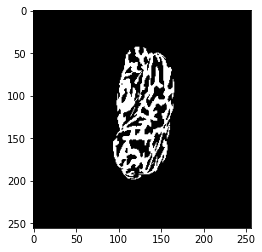

In [61]:
plt.imshow(x[:, :, 3], cmap='gray')

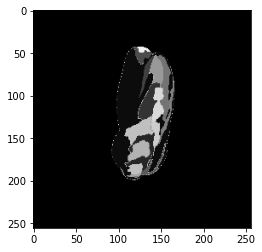

In [62]:
plt.imshow(y, cmap='gray')

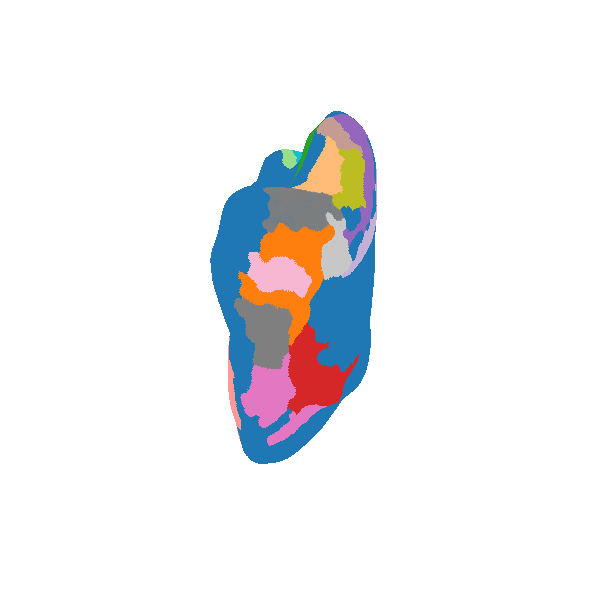

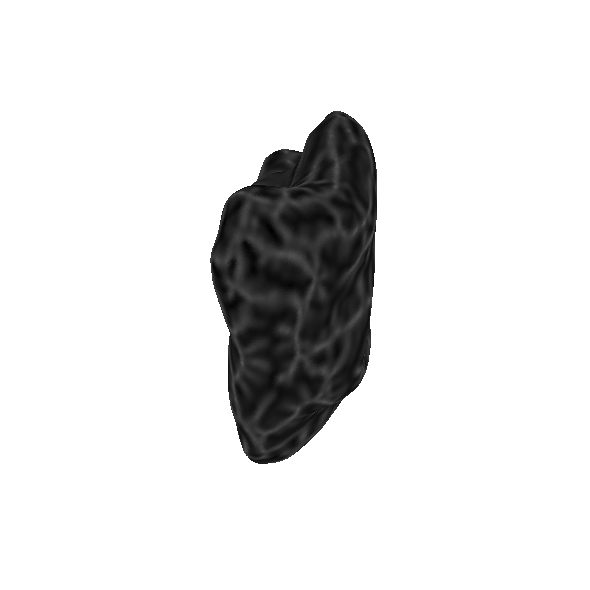

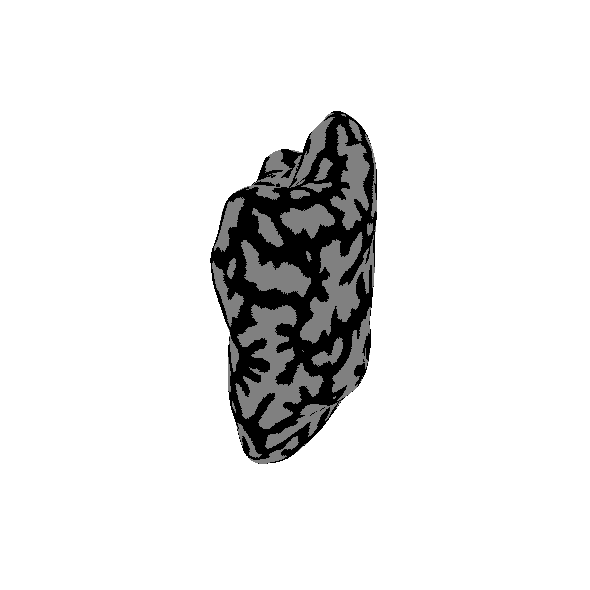

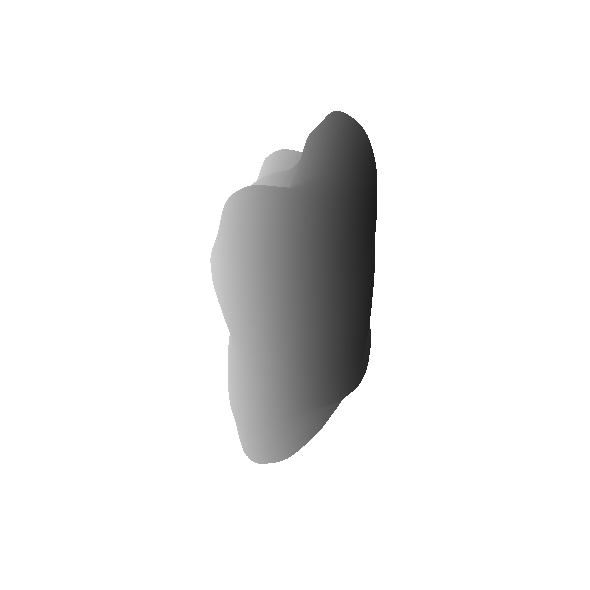

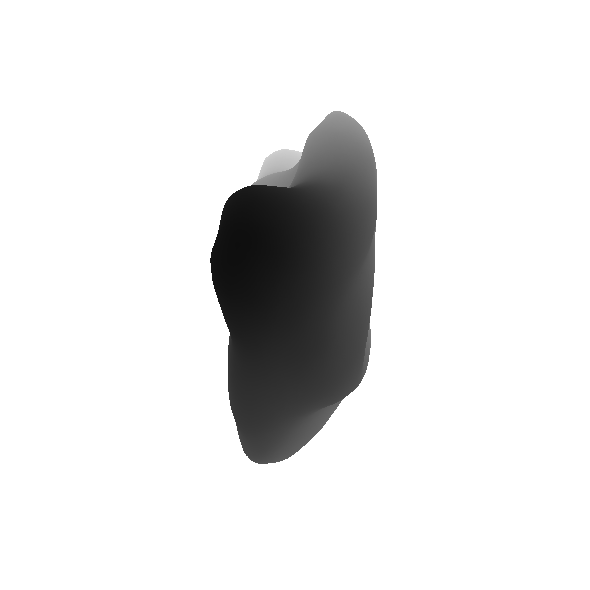

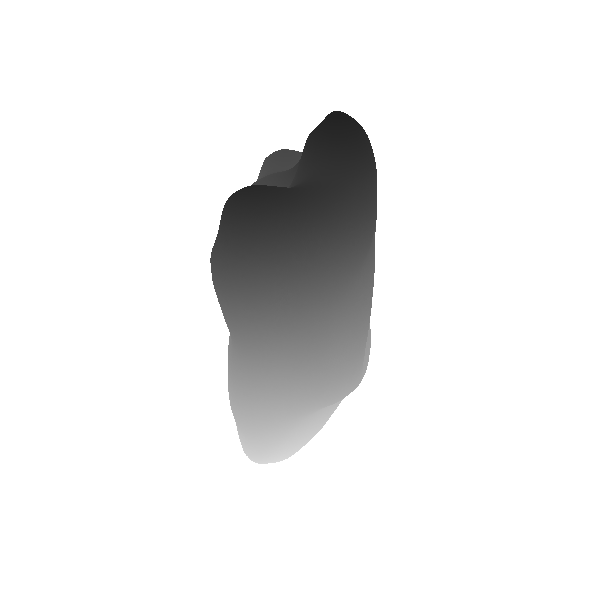

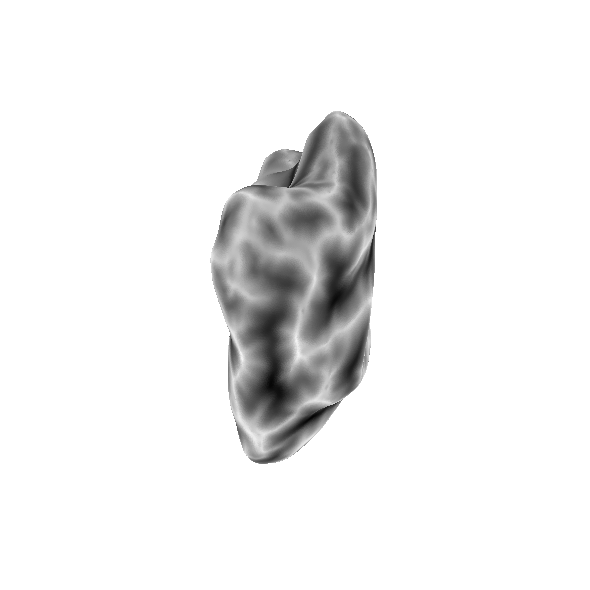

In [46]:
fig_dict

{'mask': [<Figure size 576x576 with 2 Axes>],
 'curv': [<Figure size 576x576 with 2 Axes>],
 'parc': [<Figure size 576x576 with 2 Axes>],
 'xcoord': [<Figure size 576x576 with 2 Axes>],
 'ycoord': [<Figure size 576x576 with 2 Axes>],
 'zcoord': [<Figure size 576x576 with 2 Axes>],
 'angles': array([[197.22526751,  83.58569166]]),
 'lh.sulc': [<Figure size 576x576 with 2 Axes>]}

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


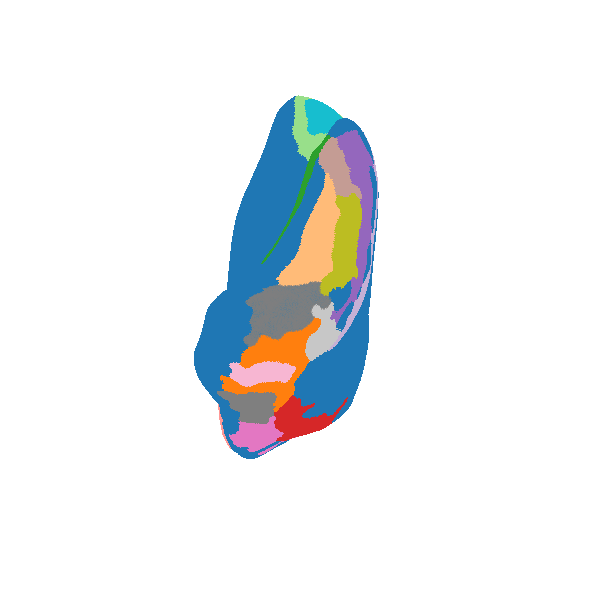

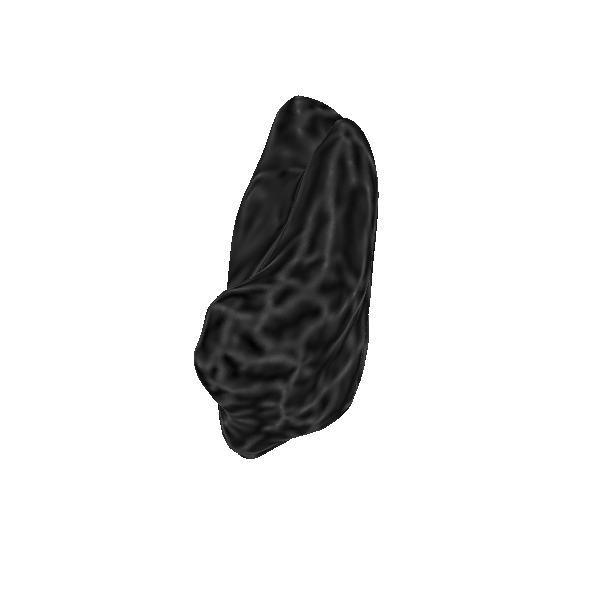

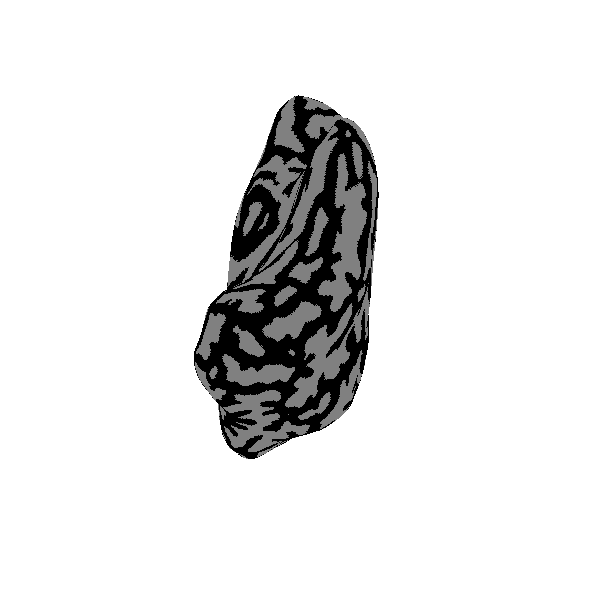

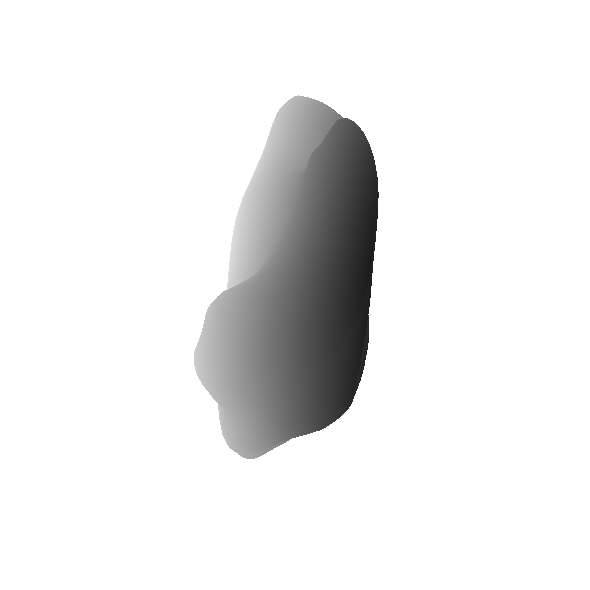

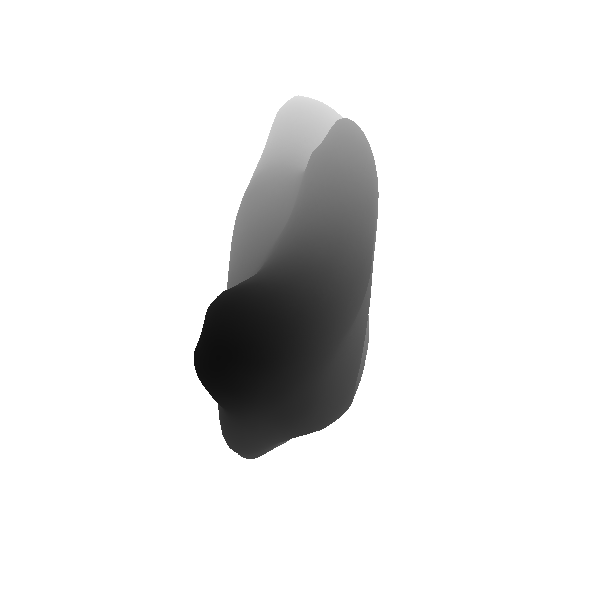

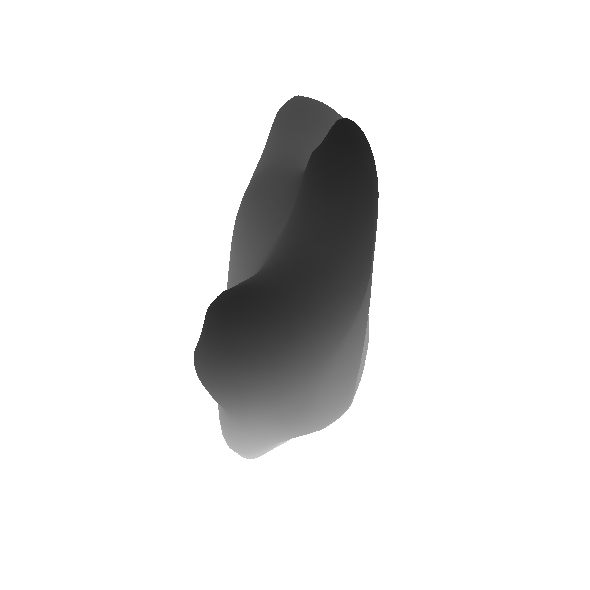

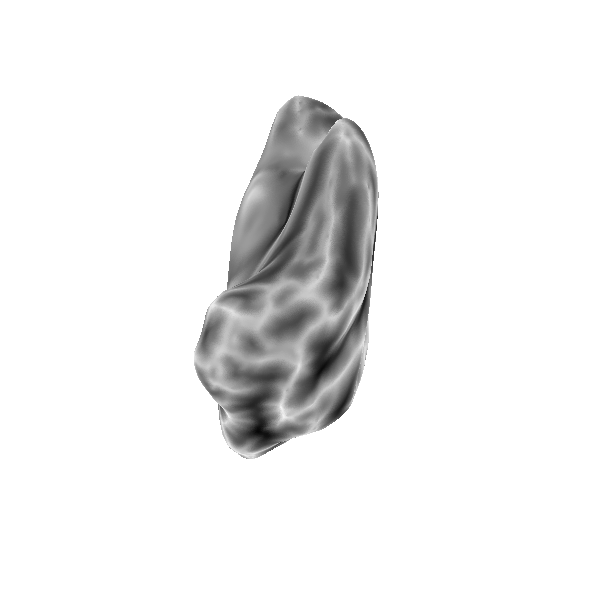

In [1]:
import os
import sys
import pipeline_utilities as pu
import matplotlib.pyplot as plt

#start = int(sys.argv[1])
#end = int(sys.argv[2])
start, end = 0, 1  # change values during testing

hbn_dir = '/oak/stanford/groups/jyeatman/HBN/BIDS_curated/derivatives/freesurfer'
hbn_subjects = [s for s in os.listdir(hbn_dir) if s[:4]=='sub-']

save_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data/atlas'
save_x_subdir = 'xs'
save_y_subdir = 'ys'
save_xdir = os.path.join(save_base_dir, save_x_subdir)
save_ydir = os.path.join(save_base_dir, save_y_subdir)

save_px2v_subdir = 'px2v'
save_pxcoord_subdir = 'pxcoord'
save_px2v_dir = os.path.join(save_base_dir, save_px2v_subdir)
save_pxcoord_dir = os.path.join(save_base_dir, save_pxcoord_subdir)

os.makedirs(save_base_dir, exist_ok=True)
os.makedirs(save_xdir, exist_ok=True)
os.makedirs(save_ydir, exist_ok=True)
os.makedirs(save_px2v_dir, exist_ok=True)
os.makedirs(save_pxcoord_dir, exist_ok=True)

parc_fn = 'lh.aparc.a2009s.annot'  # Destrieux parcellation
curv_fn = 'lh.curv'
mesh_fn = 'lh.inflated'
extra_channel_fns = ['lh.sulc']

run = True
if run:
    
    for sub in hbn_subjects[start:end]:

        subj_fp = os.path.join(hbn_dir, sub)
        subject_data = pu.get_freesurfer_subject_with_parc(subj_fp,
                                                        [mesh_fn], 
                                                        [curv_fn] + extra_channel_fns, 
                                                        label_files = [parc_fn])

        mesh = subject_data[mesh_fn]
        curv = subject_data[curv_fn]
        parc = subject_data[parc_fn]
        extra_channels_dict = {k: subject_data[k] for k in extra_channel_fns}
        
        fig_dict = pu.make_subject_images(mesh, 
                                          curv, 
                                          parc, 
                                          extra_channels_dict=extra_channels_dict,
                                          nangles=1)
        np_dict = pu.process_figs(fig_dict)
        np_px_dict = pu.px2v_from_np_dict(np_dict, 
                                  mesh_coords=mesh.coordinates)
        pu.save_subject_npys(sub, np_px_dict, test_xdir, test_ydir, 
                     extra_channel_keys=['lh.sulc'],
                     save_px2v_dir=test_px2v_dir, 
                     save_pxcoord_dir=test_pxcoord_dir)

In [3]:
test_xdir = './test/test_xs'
test_ydir = './test/test_ys'
test_px2v_dir = './test/test_px2v'
test_pxcoord_dir = './test/test_pxcoord'
os.makedirs(test_xdir)
os.makedirs(test_ydir)
os.makedirs(test_px2v_dir)
os.makedirs(test_pxcoord_dir)